In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import yfinance as yf
from models import BlackLittermanOptimizer
from datetime import datetime


# Install yfinance if needed: !pip install yfinance
import datetime


# Section 1: Setup


## Load Tickers

In [21]:
from datetime import datetime
tickers = [
    'AAPL', 
    'MSFT', 
    'GOOGL', 
    ]
years = 5


start_date = datetime.now() - pd.Timedelta(days=365*years)
end_date = datetime.now()



In [23]:
hist_data = pd.DataFrame()

for ticker in tickers:
    hist_data[ticker] = yf.download(ticker, start=start_date, end=end_date)['Adj Close']

print("Historical Adjusted Close Prices (Sample):")
display(hist_data.head())




[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Historical Adjusted Close Prices (Sample):


,AAPL,MSFT,GOOGL
Date,,,
2019-12-11,65.626701,145.098846,67.046486
2019-12-12,65.793930,146.571823,67.257957
2019-12-13,66.688293,147.805695,67.177162
2019-12-16,67.829842,148.762192,67.866959
2019-12-17,67.963150,147.958755,67.577164


## Calculate Log Returns
$$
\text{Log Returns} = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$



In [24]:
log_returns = np.log(hist_data / hist_data.shift(1))
log_returns.dropna(inplace=True)

print("\nLog Returns (Sample):")
display(log_returns.head())  # Show sample of log returns


Log Returns (Sample):


,AAPL,MSFT,GOOGL
Date,,,
2019-12-12,0.002545,0.010100,0.003149
2019-12-13,0.013502,0.008383,-0.001202
2019-12-16,0.016973,0.006450,0.010216
2019-12-17,0.001963,-0.005415,-0.004279
2019-12-18,-0.002392,-0.002071,-0.002202


## Finding Covariance Matrix


 $$\text{var}(\mathbf{R}) = \begin{pmatrix} 
 \text{var}(R_A) & \text{cov}(R_A, R_B) & \text{cov}(R_A, R_C) \\ 
 \text{cov}(R_B, R_A) & \text{var}(R_B) & \text{cov}(R_B, R_C) \\ 
 \text{cov}(R_C, R_A) & \text{cov}(R_C, R_B) & \text{var}(R_C) 
 \end{pmatrix}$$
 
 $$= \begin{pmatrix} 
 \sigma_A^2 & \sigma_{AB} & \sigma_{AC} \\ 
 \sigma_{AB} & \sigma_B^2 & \sigma_{BC} \\ 
 \sigma_{AC} & \sigma_{BC} & \sigma_C^2 
 \end{pmatrix} = \Sigma.$$


In [25]:
# Covariance matrix using Ledoit-Wolf shrinkage
cov_matrix = log_returns.cov() * 252
print("\nCovariance Matrix:")
print(cov_matrix)



Covariance Matrix:
           AAPL      MSFT     GOOGL
AAPL   0.100278  0.072477  0.067119
MSFT   0.072477  0.092961  0.073984
GOOGL  0.067119  0.073984  0.104177


## Finding Market-Implied Returns

$$
\boldsymbol{\pi} = \delta \Sigma \mathbf{w}
$$
Where:

- $\pi$ is the vector of market-implied returns.
- $\delta$ is the risk aversion parameter.
- $\Sigma$ is the covariance matrix of asset returns.

In [26]:
# Instantiate the optimizer
optimizer = BlackLittermanOptimizer()

# Get market capitalizations (or use dummy values)
market_caps = optimizer.get_market_caps(tickers)

# Calculate market-implied returns
risk_aversion = 2.5  # Default value
market_prior = optimizer.calculate_implied_returns(market_caps, cov_matrix, risk_aversion)

print("\nMarket-Implied Returns (π):")
for ticker, ret in zip(tickers, market_prior):
    print(f"{ticker}: {ret:.4f}")


Market-Implied Returns (π):
AAPL: 0.2062
MSFT: 0.2005
GOOGL: 0.1957


## Black Litterman Model without Investor Views

In [32]:
# Optimize the portfolio without investor views (baseline)
results_without_views = optimizer.optimize_portfolio(
    market_prior,  # Market-implied returns
    cov_matrix,    # Historical covariance matrix
    tickers        # List of tickers
)

# Display baseline portfolio weights and performance metrics
print("\nOptimized Portfolio Weights (Without Views):")
for ticker, weight in results_without_views['weights'].items():
    print(f"{ticker}: {weight:.4f}")

print(f"\nExpected Annual Return (Without Views): {results_without_views['expected_return']:.4f}")
print(f"Annual Volatility (Without Views): {results_without_views['volatility']:.4f}")
print(f"Sharpe Ratio (Without Views): {results_without_views['sharpe_ratio']:.4f}")



Optimized Portfolio Weights (Without Views):
AAPL: 0.4227
MSFT: 0.3573
GOOGL: 0.2200

Expected Annual Return (Without Views): 0.2019
Annual Volatility (Without Views): 0.2843
Sharpe Ratio (Without Views): 0.5627


## Investor Views using News Sentiment Analysis

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  1 of 1 completed


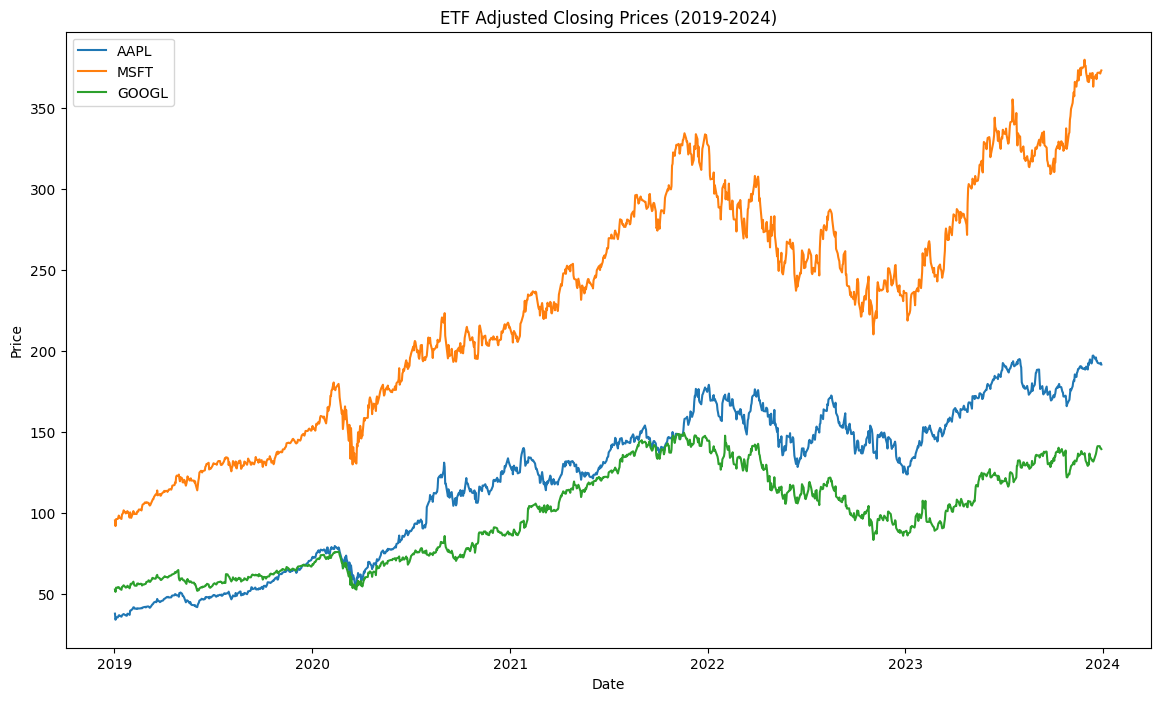

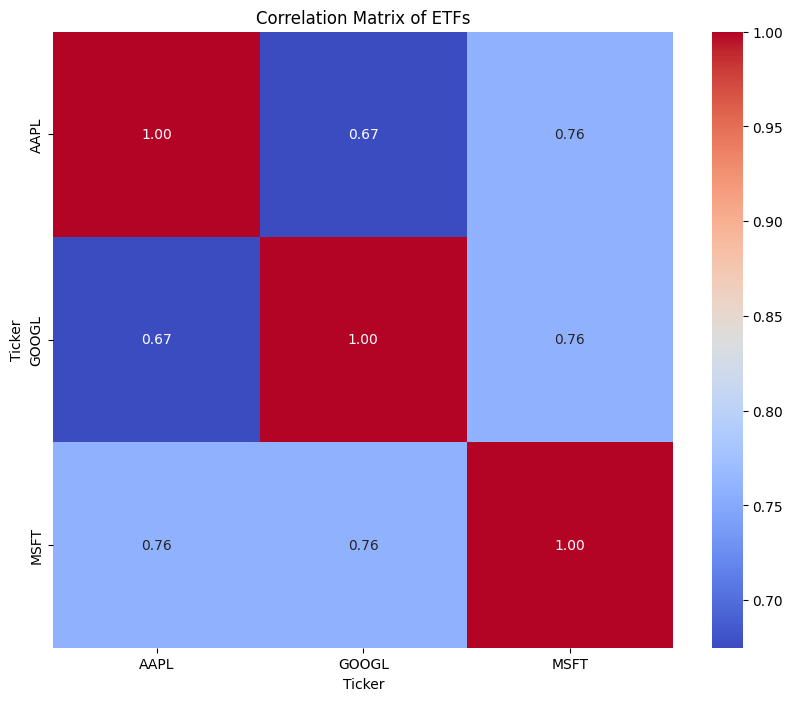

[0.06518206075431543, 0.04328524998257662, 0.016940876793269076]
Random Views:
AAPL: -0.0323
MSFT: 0.1183
GOOGL: -0.0572

Random Certainty Intervals:
AAPL: (-0.287599533993671, 0.22301601905701873)
MSFT: (-0.08972682179050556, 0.3263753290454478)
GOOGL: (-0.18735543583889402, 0.07295881112633895)
\Weights for randomized data: OrderedDict([('AAPL', 0.36813), ('GOOGL', 0.28939), ('MSFT', 0.34248)])
Optimized portfolio with random views and weights
Expected annual return: 22.1%
Annual volatility: 29.0%
Sharpe Ratio: 0.76


/Users/tomgansa/Desktop/VSCODE PROJECTS/portfolio-optimization/venv/lib/python3.9/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


Generated Views: {'AAPL': np.float64(-0.08000493345659968), 'MSFT': np.float64(-0.29946090745610476), 'GOOGL': np.float64(0.6956847984568513)}
Generated Confidences: {'AAPL': np.float64(0.9910517098991489), 'MSFT': np.float64(0.9910517098991489), 'GOOGL': np.float64(0.9910517098991489)}


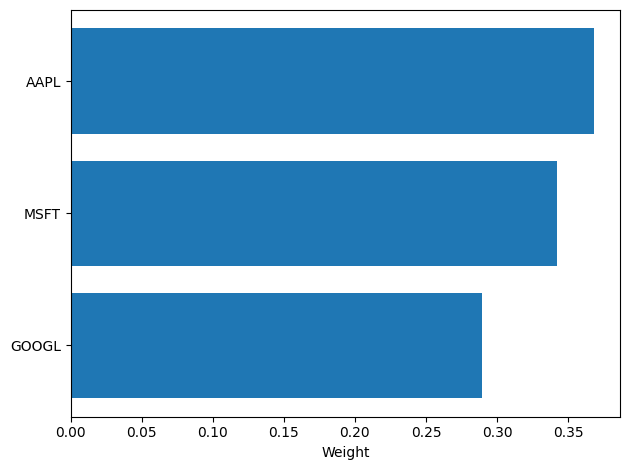

In [29]:
import blackliterman_with_sentiment_analysis
import requests
from textblob import TextBlob
from sklearn.preprocessing import MinMaxScaler

def fetch_news(symbol, api_key):
    """Fetch news headlines for a given stock symbol using NewsAPI."""
    url = f"https://newsapi.org/v2/everything?q={symbol}&apiKey={api_key}"
    response = requests.get(url)
    return response.json().get("articles", [])

def compute_sentiment_scores(articles):
    """Compute average sentiment polarity for a list of articles."""
    sentiments = []
    for article in articles:
        headline = article.get("title", "")
        if headline:
            sentiment = TextBlob(headline).sentiment.polarity
            sentiments.append(sentiment)
    return np.mean(sentiments) if sentiments else 0

def generate_views(sentiment_scores, baseline_returns, scaling_factor=0.5):
    """Combine baseline returns with normalized sentiment scores."""
    normalized_sentiments = MinMaxScaler(feature_range=(-scaling_factor, scaling_factor)).fit_transform(
        np.array(sentiment_scores).reshape(-1, 1)
    ).flatten()
    return {symbol: baseline + sentiment for symbol, baseline, sentiment in zip(tickers, baseline_returns, normalized_sentiments)}

def calculate_confidence(sentiments):
    """Calculate confidence levels based on sentiment variability."""
    std_dev = np.std(sentiments) if len(sentiments) > 1 else 1  # Prevent zero division
    return 1 / (1 + std_dev)  # Higher variability -> Lower confidence



NEWS_API_KEY = "684b174a63e046cabe4017e0fceced1e"  # Replace with your NewsAPI key
sentiment_scores = []
for ticker in tickers:
    articles = fetch_news(ticker, NEWS_API_KEY)
    sentiment_score = compute_sentiment_scores(articles)
    sentiment_scores.append(sentiment_score)

# Generate views based on sentiment
views = generate_views(sentiment_scores, market_prior)

# Calculate confidences
confidences = {ticker: calculate_confidence(sentiment_scores) for ticker in tickers}

print("Generated Views:", views)
print("Generated Confidences:", confidences)

In [30]:
# Optimize portfolio using market priors
posterior_returns, posterior_covariance = optimizer.incorporate_views(
    prior_returns=market_prior,
    views=views,
    confidences=confidences,
    tickers=tickers,
    cov_matrix=cov_matrix
)

print("\nPosterior Returns (Adjusted by Views):")
for ticker, ret in zip(tickers, posterior_returns):
    print(f"{ticker}: {ret:.4f}")

print("\nPosterior Covariance Matrix:")
print(posterior_covariance)


Posterior Returns (Adjusted by Views):
AAPL: 0.2047
MSFT: 0.1991
GOOGL: 0.1955

Posterior Covariance Matrix:
[[0.00496536 0.0035774  0.00330926]
 [0.0035774  0.00460061 0.0036516 ]
 [0.00330926 0.0036516  0.00515782]]


In [31]:
# Optimize the portfolio
results = optimizer.optimize_portfolio(posterior_returns, posterior_covariance, tickers)

# Output portfolio weights and performance metrics
print("\nOptimized Portfolio Weights (Sentiment-Informed):")
for ticker, weight in results['weights'].items():
    print(f"{ticker}: {weight:.4f}")

print(f"\nExpected Annual Return: {results['expected_return']:.4f}")
print(f"Annual Volatility: {results['volatility']:.4f}")
print(f"Sharpe Ratio: {results['sharpe_ratio']:.4f}")



Optimized Portfolio Weights (Sentiment-Informed):
AAPL: 0.4170
MSFT: 0.3481
GOOGL: 0.2348

Expected Annual Return: 0.2006
Annual Volatility: 0.0632
Sharpe Ratio: 2.5120


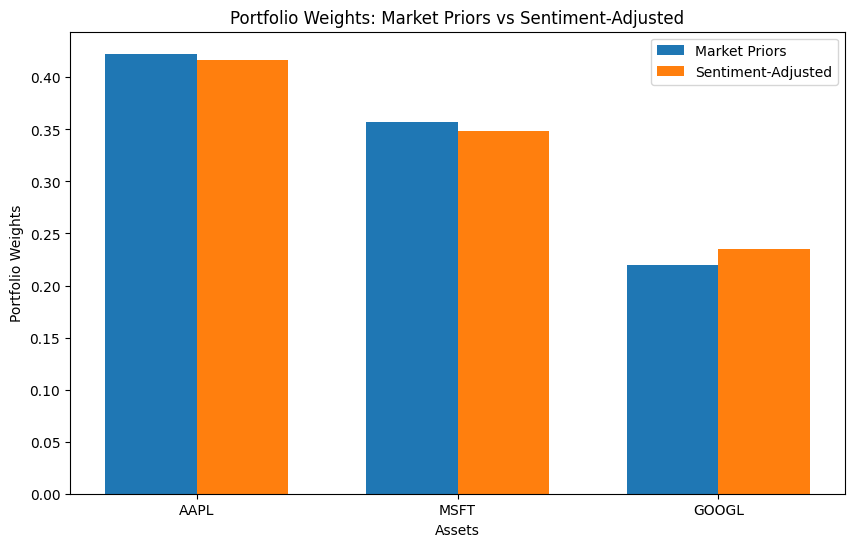

In [33]:
# Compare portfolio weights
baseline_weights = results_without_views['weights']  # From market priors only
adjusted_weights = results['weights']  # From sentiment-adjusted views

labels = tickers
baseline_values = [baseline_weights[ticker] for ticker in tickers]
adjusted_values = [adjusted_weights[ticker] for ticker in tickers]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, baseline_values, width, label="Market Priors")
ax.bar(x + width/2, adjusted_values, width, label="Sentiment-Adjusted")

ax.set_xlabel("Assets")
ax.set_ylabel("Portfolio Weights")
ax.set_title("Portfolio Weights: Market Priors vs Sentiment-Adjusted")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


## Comparing Expected Returns


Expected Return (Without Views): 0.2019

Expected Return (With Sentiment-Adjusted Views): 0.2006

Comparison of Expected Returns:
Expected Return (Without Views): 0.2019
Expected Return (With Sentiment-Adjusted Views): 0.2006


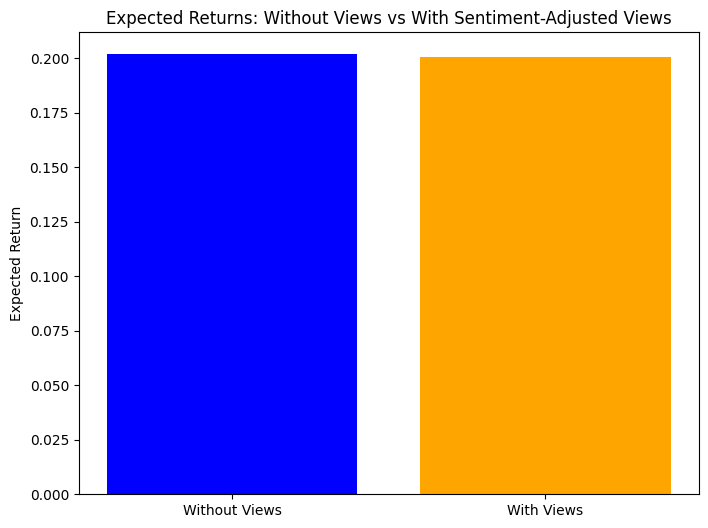

In [34]:
# Extract baseline weights and expected returns
baseline_weights = np.array([results_without_views['weights'][ticker] for ticker in tickers])
baseline_expected_return = np.dot(baseline_weights, market_prior)

print(f"\nExpected Return (Without Views): {baseline_expected_return:.4f}")

# Extract sentiment-adjusted weights and expected returns
adjusted_weights = np.array([results['weights'][ticker] for ticker in tickers])
adjusted_expected_return = np.dot(adjusted_weights, posterior_returns)

print(f"\nExpected Return (With Sentiment-Adjusted Views): {adjusted_expected_return:.4f}")

print("\nComparison of Expected Returns:")
print(f"Expected Return (Without Views): {baseline_expected_return:.4f}")
print(f"Expected Return (With Sentiment-Adjusted Views): {adjusted_expected_return:.4f}")

# Compare expected returns
labels = ['Without Views', 'With Views']
expected_returns = [baseline_expected_return, adjusted_expected_return]

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(labels, expected_returns, color=['blue', 'orange'])
ax.set_ylabel("Expected Return")
ax.set_title("Expected Returns: Without Views vs With Sentiment-Adjusted Views")
plt.show()
